In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm

import matplotlib.pyplot as plt

In [33]:
dat = pd.read_csv('data/01_standard_practice.csv')

x = dat['x'].to_numpy()
y = dat['y'].to_numpy()
sig_y = dat['sig_y'].to_numpy()

In [34]:
import decimal

def linear(x, params):
    return params[0] * x + params[1]

def gaussian(y, sigma, mu):
    return ((1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp( -(y - mu)**2 / (2 * sigma**2) ))

def likelihood(func, x, y, sig_y, params):
    '''
    Inputs:    
        y   - the dependent variable array of observed measurements
        m   - slope
        b   - intercept
        P_b - Probability of a bad point
        Y_b - mean of distribution of bad points
        V_b - variance of distribution of bad points
        sig_y - variance in y space
        
    Outputs:
        likelihood = p({y_i} | m, b, P_b, Y_b, V_b, I)
    '''
    
    m = params[0]
    b = params[1]
    P_b = params[2]
    Y_b = params[3]
    V_b = params[4]
    
    likelihood = 1
    
    for i in range(len(x)):        
        foreground = gaussian(y[i], sig_y[i], func(x[i], [m, b]))
        background = gaussian(y[i], np.sqrt(V_b + sig_y[i]**2), Y_b)
        #print(((1 - P_b) * foreground) + ((P_b) * background))
        
        likelihood *= ((1 - P_b) * foreground) + ((P_b) * background)
        
    return likelihood

In [35]:
import random
import pandas as pd

def metropolis_hastings(kernel, func, x, y, sig_y, params, steps = 5000, stepsize = 0.005):
    param_set = []
        
    param_array = []
    param_ub = []
    param_lb = []
        
    '''
    
    Initialize chain
    
    '''
        
    for key in params.keys():
        param_array.append(params[key][0])
        param_ub.append(params[key][1])
        param_lb.append(params[key][2])
        
    likelihood = kernel(func, x, y, sig_y, param_array)
    tarr = param_array.copy()
    tarr.append(likelihood)    
    param_set.append(tarr)
    
    #print(param_array)
    
    '''
    
    Start stepping
    
    '''
    
    for i in tqdm(range(steps)):
        #print(param_set)
        #print(param_array)
        prev_param_array = param_array
        prev_likelihood = param_set[-1][-1]
        
        for j in range(len(param_array)):
            newparam = random.gauss(prev_param_array[j], stepsize)
            if j in [2]:
                #print('bleh')
                #newparam = random.uniform(param_lb[j], param_ub[j])                
                while (newparam < 0) or (newparam > 1):
                    newparam = random.gauss(prev_param_array[j], stepsize)
                #print('blah')
            
            param_array[j] = newparam
            
        likelihood = kernel(func, x, y, sig_y, param_array)
        R = random.uniform(0, 1)
        
        if R < (likelihood / prev_likelihood):
            tarr = param_array.copy()
            tarr.append(likelihood)
            param_set.append(tarr)
        else:            
            tarr = prev_param_array.copy()
            tarr.append(prev_likelihood)
            param_set.append(tarr)
            
    columns = []
    for key in params.keys():
        columns.append(key)
    columns.append('likelihood')
            
    df = pd.DataFrame(np.array(param_set), columns = columns)
    
    return df

'''
initial value, upper bound, lower bound
'''
        
params = {'m' : np.array([2, 0, 5]),
            'b' : np.array([30, 20, 40]),
            'P_b' : np.array([0.1, 0, 1]),
            'Y_b' : np.array([0, -100, 100]),
            'V_b' : np.array([10, -100, 100])}

df = metropolis_hastings(likelihood, linear, x, y, sig_y, params)


100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2526.66it/s]


In [36]:
print(df)

#df[['V_b']]

             m          b       P_b       Y_b        V_b     likelihood
0     2.000000  30.000000  0.100000  0.000000  10.000000  1.368917e-135
1     2.001321  30.006285  0.096041  0.005442   9.995271  1.531169e-135
2     1.993130  30.002363  0.092679  0.005720   9.996318  1.402993e-135
3     1.999368  30.003020  0.093394  0.003328   9.999944  1.573798e-135
4     2.004059  30.001491  0.095027  0.001580  10.003158  1.604571e-135
...        ...        ...       ...       ...        ...            ...
4996  2.490985  30.417977  0.616577 -0.055468  10.392281  8.661608e-143
4997  2.494521  30.420885  0.612977 -0.064269  10.389522  8.661608e-143
4998  2.486106  30.418510  0.617712 -0.062304  10.385154  8.661608e-143
4999  2.485585  30.413783  0.614263 -0.065335  10.391336  8.661608e-143
5000  2.484312  30.406515  0.616624 -0.068146  10.382602  8.661608e-143

[5001 rows x 6 columns]


In [37]:
from scipy.integrate import trapezoid
import numpy as np

df['marginalized'] = trapezoid(df['likelihood'], x = df['V_b'])
#print(df)

print(df)

             m          b       P_b       Y_b        V_b     likelihood  \
0     2.000000  30.000000  0.100000  0.000000  10.000000  1.368917e-135   
1     2.001321  30.006285  0.096041  0.005442   9.995271  1.531169e-135   
2     1.993130  30.002363  0.092679  0.005720   9.996318  1.402993e-135   
3     1.999368  30.003020  0.093394  0.003328   9.999944  1.573798e-135   
4     2.004059  30.001491  0.095027  0.001580  10.003158  1.604571e-135   
...        ...        ...       ...       ...        ...            ...   
4996  2.490985  30.417977  0.616577 -0.055468  10.392281  8.661608e-143   
4997  2.494521  30.420885  0.612977 -0.064269  10.389522  8.661608e-143   
4998  2.486106  30.418510  0.617712 -0.062304  10.385154  8.661608e-143   
4999  2.485585  30.413783  0.614263 -0.065335  10.391336  8.661608e-143   
5000  2.484312  30.406515  0.616624 -0.068146  10.382602  8.661608e-143   

       marginalized  
0    -6.438850e-137  
1    -6.438850e-137  
2    -6.438850e-137  
3    -6.438

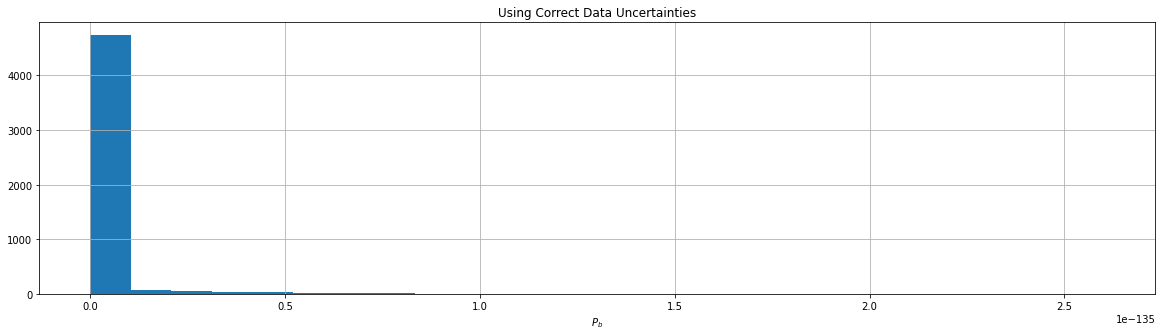

In [38]:
plt.figure(figsize=(20,5))
#plt.subplot(1, 2, 1)
plt.hist(df['likelihood'], bins = 25)
plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$P_b$')
plt.grid()

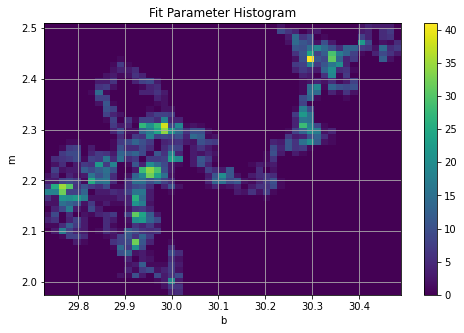

In [39]:
#param_set = df.to_dict()
likelihoods = df['likelihood']
m = df['m']
b = df['b']

y_min = np.min(m)
y_max = np.max(m)

x_min = np.min(b)
x_max = np.max(b)

x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 50)

plt.figure(figsize=(8,5))

#plt.xlim(-100, 100)
#plt.ylim(1.5, 3)
plt.hist2d(b, m, bins =[x_bins, y_bins])
plt.title("Fit Parameter Histogram")

plt.xlabel('b')
plt.ylabel('m')
plt.grid()
plt.colorbar()


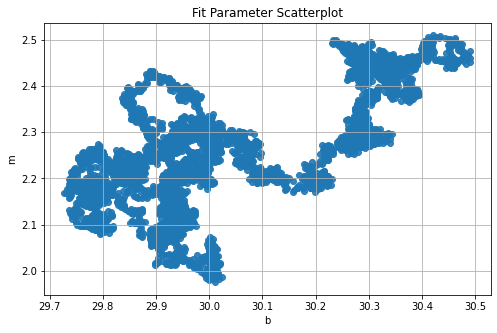

In [40]:
plt.figure(figsize=(8,5))

plt.scatter(b, m, alpha = 0.9)

plt.title("Fit Parameter Scatterplot")
plt.xlabel('b')
plt.ylabel('m')
#plt.xlim(29.25,30.5)
#plt.ylim(1.5,3.2)
plt.grid()

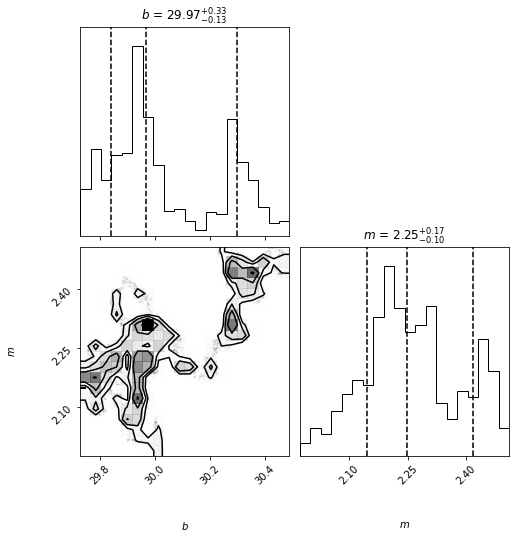

In [41]:
import corner
import numpy as np

samples = np.array([b, m]).T
figure = corner.corner(samples, labels=[r"$b$", r"$m$"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure.set_size_inches(8,8)

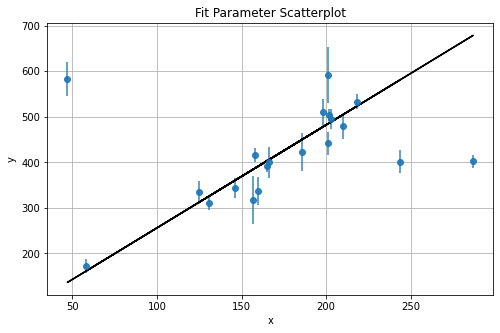

In [42]:
mval = np.mean(m)
bval = np.mean(b)

plt.figure(figsize=(8,5))

plt.errorbar(x, y, yerr = sig_y, alpha = 0.9, fmt = 'o')

plt.plot(x, linear(x, [mval, bval]), color = 'black')

plt.title("Fit Parameter Scatterplot")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


In [43]:
param_set = metropolis_hastings(likelihood, linear, x, y, sig_y, params, steps = 15000)
P_b = param_set['P_b']
m, b = param_set['m'], param_set['b']

param_set = metropolis_hastings(likelihood, linear, x, y, sig_y / 2, params, steps = 15000)
P_b2  = param_set['P_b']

  0%|                                                                                 | 0/15000 [00:00<?, ?it/s]/tmp/ipykernel_18242/88080216.py:55: RuntimeWarning: invalid value encountered in double_scalars
  if R < (likelihood / prev_likelihood):
100%|███████████████████████████████████████████████████████████████████| 15000/15000 [00:05<00:00, 2787.66it/s]


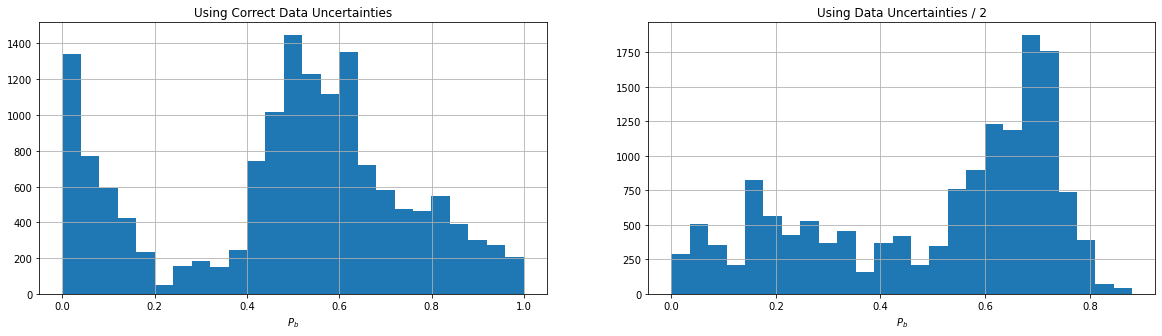

In [44]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(P_b, bins = 25)
plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$P_b$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(P_b2, bins = 25)
plt.title("Using Data Uncertainties / 2")
plt.xlabel(r'$P_b$')
plt.grid()

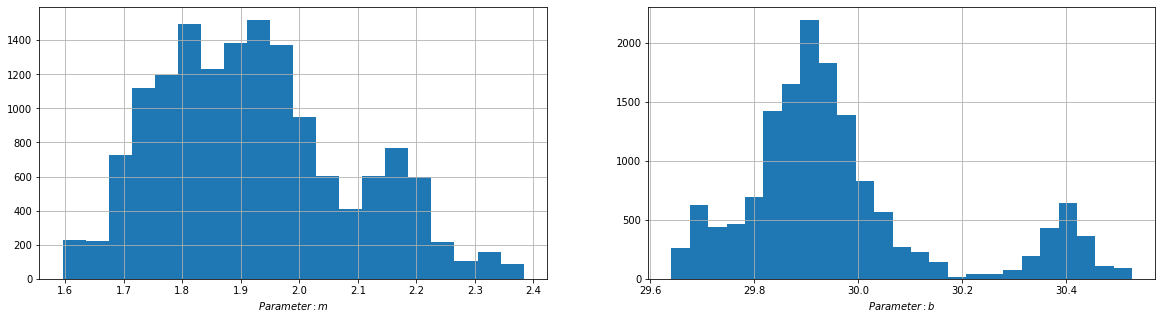

In [45]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(m, bins = 20)
#plt.title("m")
plt.xlabel(r'$Parameter: m$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(b, bins = 25)
#plt.title("b")
plt.xlabel(r'$Parameter: b$')
plt.grid()

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1783.28it/s]

==== fit report ====
  m = 2.20 +/- 0.21
  b = 29.77 +/- 0.28


In [48]:
def jackknife(fitter, kernel, function, x, y, sig_y, params, steps = 5000, stepsize = 0.005):        
    m, b, df_all = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)    
    N = len(x)
    
    m_list = []
    b_list = []
    
    for i in range(N):
        tempx = np.delete(x, i)
        tempy = np.delete(y, i)
        tempsigy = np.delete(sig_y, i)
        
        m_i, b_i, df = fitter(kernel, function, x, y, sig_y, params, steps, stepsize)
        m_list.append(m_i)
        b_list.append(b_i)
        
    m = (1 / len(m_list)) * sum(m_list)
    b = (1 / len(b_list)) * sum(b_list)
    
    sig_m = 0
    sig_b = 0
    sig_mb = 0
    
    for i in range(len(m_list)):
        sig_m += (m_list[i] - m)**2
        sig_b += (b_list[i] - b)**2
        sig_mb += (m_list[i] - m) * (b_list[i] - b)
    
    sig_m *= (N - 1) / N
    sig_b *= (N - 1) / N
    sig_mb *= (N - 1) / N
    
    cov = np.array([[sig_b, sig_mb],[sig_mb, sig_m]])
    return m, b, cov

m, b, cov = jackknife(get_params, likelihood, linear, x, y, sig_y, params)

print('==== fit report ====\n  m = %2.2f +/- %2.2f\n  b = %2.2f +/- %2.2f' % (m, np.sqrt(cov[1][1]), b, np.sqrt(cov[0][0])))

100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2416.25it/s]

==== fit report ====
  m = 2.08 +/- 0.87
  b = 30.01 +/- 0.76
